In [1]:
# Imports
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import json
from pathlib import Path
import random

print(f"TensorFlow version: {tf.__version__}")

2026-01-03 13:29:55.007804: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-03 13:29:55.016649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767439795.027358   93378 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767439795.030146   93378 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767439795.038141   93378 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0


In [2]:
# Configuration - Update this path to your model
MODEL_DIR = Path('../trained_models').resolve()

# Find the latest model directory
model_dirs = sorted([d for d in MODEL_DIR.iterdir() if d.is_dir()], reverse=True)
if model_dirs:
    LATEST_MODEL = model_dirs[0]
    print(f"Using latest model: {LATEST_MODEL.name}")
else:
    raise FileNotFoundError("No trained models found!")

TFLITE_MODEL_PATH = LATEST_MODEL / 'face_recognition_int8.tflite'
CLASS_LABELS_PATH = LATEST_MODEL / 'class_labels.json'
DATASET_PATH = Path('../dataset').resolve()

print(f"TFLite model: {TFLITE_MODEL_PATH}")
print(f"Model exists: {TFLITE_MODEL_PATH.exists()}")

Using latest model: model_20260103_132805
TFLite model: /mnt/oxa/SpaceRocket/SpaceRocket/Work/NTI/Technical/active_projects/Graduation_Project/smart-hotel/esp32-cam/trained_models/model_20260103_132805/face_recognition_int8.tflite
Model exists: True


In [3]:
# Load class labels
with open(CLASS_LABELS_PATH, 'r') as f:
    class_labels = json.load(f)

# Convert keys from string to int
class_labels = {int(k): v for k, v in class_labels.items()}
print(f"Class labels: {class_labels}")
print(f"Number of classes: {len(class_labels)}")

Class labels: {0: 'maha', 1: 'mokhtar', 2: 'omar', 3: 'radwan', 4: 'tarek'}
Number of classes: 5


In [4]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=str(TFLITE_MODEL_PATH))
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\n=== Model Input Details ===")
print(f"Shape: {input_details[0]['shape']}")
print(f"Type: {input_details[0]['dtype']}")

print("\n=== Model Output Details ===")
print(f"Shape: {output_details[0]['shape']}")
print(f"Type: {output_details[0]['dtype']}")


=== Model Input Details ===
Shape: [ 1 96 96  3]
Type: <class 'numpy.uint8'>

=== Model Output Details ===
Shape: [1 5]
Type: <class 'numpy.uint8'>


/home/oxa/anaconda3/envs/tensor-gpu/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [5]:
def preprocess_image(image_path, target_size=None):
    """Load and preprocess an image for the model"""
    input_shape = input_details[0]['shape']
    height, width = input_shape[1], input_shape[2]
    if target_size is None:
        target_size = (width, height)
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img)
    if input_details[0]['dtype'] == np.uint8:
        img_array = img_array.astype(np.uint8)
    else:
        img_array = img_array.astype(np.float32)
        img_array = (img_array / 127.5) - 1.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img

def predict(interpreter, image_array):
    """Run inference on an image"""
    interpreter.set_tensor(input_details[0]['index'], image_array)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    # Normalize output if quantized (uint8)
    if output_details[0]['dtype'] == np.uint8:
        # Typical quantized output: [0, 255] -> [0, 1]
        output = output.astype(np.float32) / 255.0
    return output[0]  # Remove batch dimension

def get_prediction(image_path):
    """Get prediction for a single image"""
    img_array, original_img = preprocess_image(image_path)
    predictions = predict(interpreter, img_array)
    
    predicted_class = np.argmax(predictions)
    confidence = predictions[predicted_class]
    
    return {
        'class_id': predicted_class,
        'class_name': class_labels[predicted_class],
        'confidence': confidence,
        'all_predictions': predictions,
        'image': original_img
    }

print("Prediction functions defined ✓")

Prediction functions defined ✓


## Test on Random Images from Dataset

In [6]:
# Get random test images from each class
test_images = []

for class_id, class_name in class_labels.items():
    class_dir = DATASET_PATH / class_name
    if class_dir.exists():
        images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
        if images:
            # Pick 2 random images per class
            selected = random.sample(images, min(2, len(images)))
            for img_path in selected:
                test_images.append((img_path, class_name))

random.shuffle(test_images)
print(f"Selected {len(test_images)} test images")

Selected 10 test images


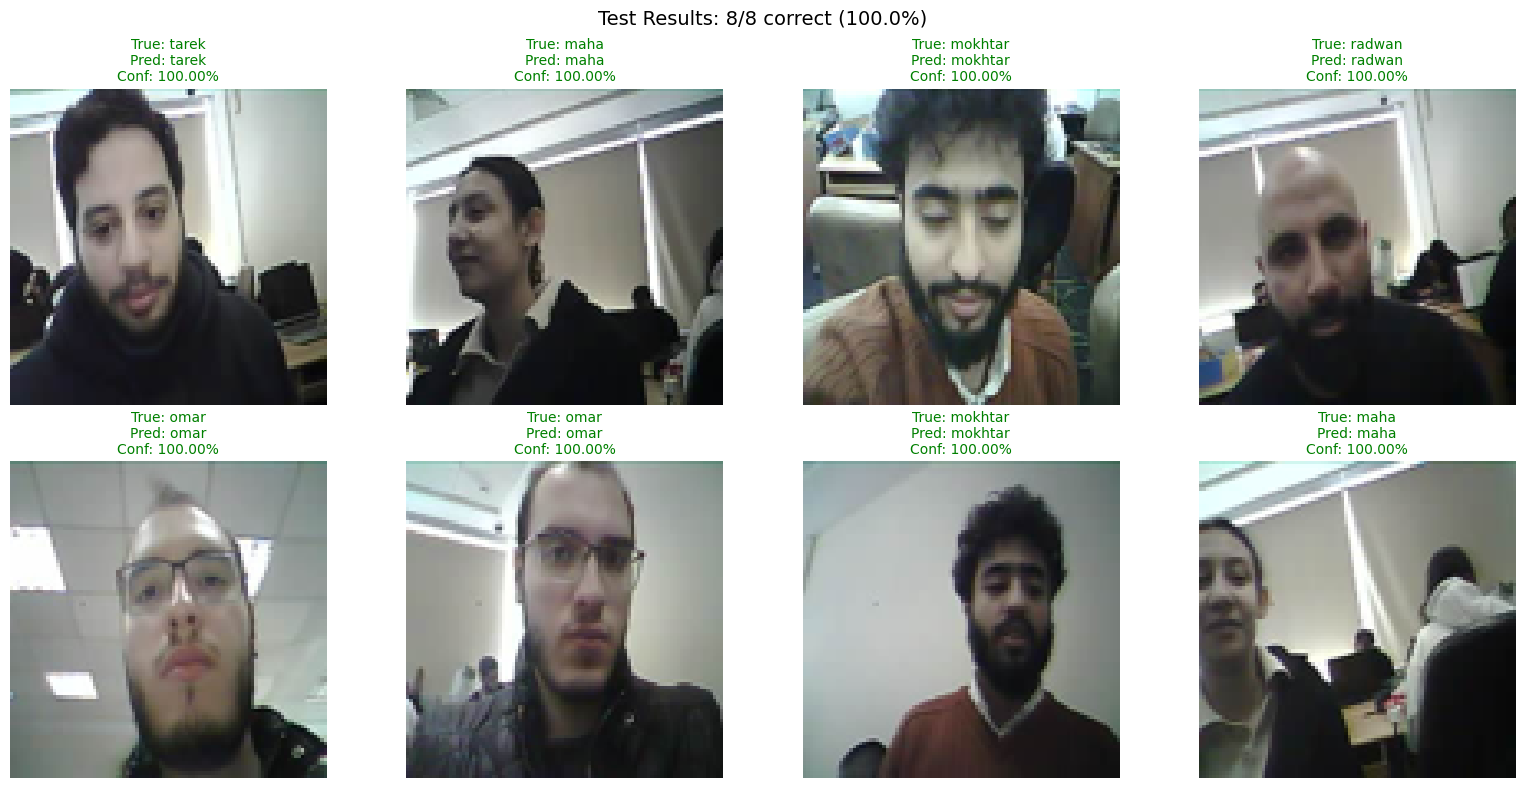

In [7]:
# Run predictions and visualize
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

correct = 0
total = min(8, len(test_images))

for idx, (img_path, true_label) in enumerate(test_images[:8]):
    result = get_prediction(img_path)
    
    is_correct = result['class_name'] == true_label
    if is_correct:
        correct += 1
    
    # Plot
    ax = axes[idx]
    ax.imshow(result['image'])
    
    color = 'green' if is_correct else 'red'
    title = f"True: {true_label}\nPred: {result['class_name']}\nConf: {result['confidence']:.2%}"
    ax.set_title(title, color=color, fontsize=10)
    ax.axis('off')

# Hide empty subplots
for idx in range(len(test_images), 8):
    axes[idx].axis('off')

plt.suptitle(f"Test Results: {correct}/{total} correct ({correct/total*100:.1f}%)", fontsize=14)
plt.tight_layout()
plt.show()

## Detailed Prediction Analysis


=== Prediction Details ===
Image: image_027.jpg
True label: tarek
Predicted: tarek
Confidence: 100.00%

=== All Class Probabilities ===
  maha        : 0.0000 (0.00%)
  mokhtar     : 0.0000 (0.00%)
  omar        : 0.0000 (0.00%)
  radwan      : 0.0000 (0.00%)
  tarek       : 1.0000 (100.00%)  ←


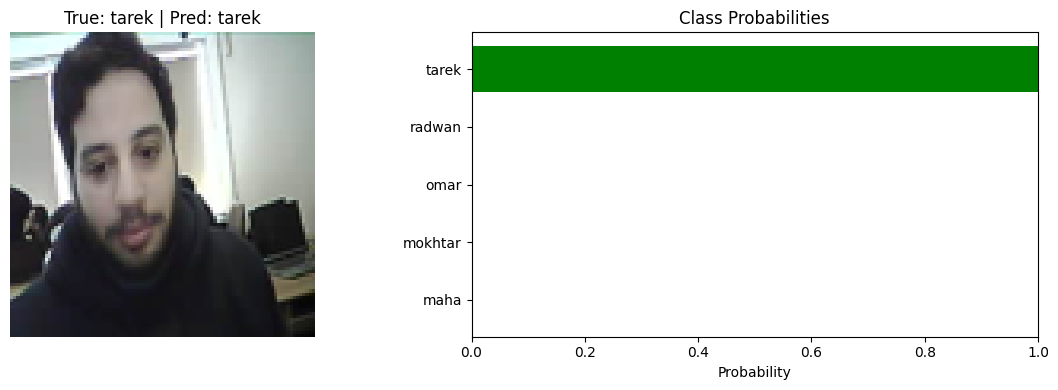

In [8]:
# Test on a specific image with detailed output
if test_images:
    test_img_path, true_label = test_images[0]
    result = get_prediction(test_img_path)
    
    print(f"\n=== Prediction Details ===")
    print(f"Image: {test_img_path.name}")
    print(f"True label: {true_label}")
    print(f"Predicted: {result['class_name']}")
    print(f"Confidence: {result['confidence']:.2%}")
    
    print(f"\n=== All Class Probabilities ===")
    for class_id, prob in enumerate(result['all_predictions']):
        marker = "  ←" if class_id == result['class_id'] else ""
        print(f"  {class_labels[class_id]:12s}: {prob:.4f} ({prob*100:.2f}%){marker}")
    
    # Visualize probabilities
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.imshow(result['image'])
    ax1.set_title(f"True: {true_label} | Pred: {result['class_name']}")
    ax1.axis('off')
    
    colors = ['green' if class_labels[i] == result['class_name'] else 'steelblue' 
              for i in range(len(class_labels))]
    bars = ax2.barh([class_labels[i] for i in range(len(class_labels))], 
                    result['all_predictions'], color=colors)
    ax2.set_xlabel('Probability')
    ax2.set_title('Class Probabilities')
    ax2.set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()

## Full Dataset Evaluation

In [9]:
# Evaluate on entire dataset
from collections import defaultdict

results = defaultdict(lambda: {'correct': 0, 'total': 0, 'confidences': []})

for class_id, class_name in class_labels.items():
    class_dir = DATASET_PATH / class_name
    if class_dir.exists():
        images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
        for img_path in images:
            try:
                result = get_prediction(img_path)
                results[class_name]['total'] += 1
                results[class_name]['confidences'].append(result['confidence'])
                if result['class_name'] == class_name:
                    results[class_name]['correct'] += 1
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)

total_correct = 0
total_samples = 0

for class_name, stats in results.items():
    accuracy = stats['correct'] / stats['total'] * 100 if stats['total'] > 0 else 0
    avg_conf = np.mean(stats['confidences']) if stats['confidences'] else 0
    print(f"\n{class_name}:")
    print(f"  Accuracy: {stats['correct']}/{stats['total']} ({accuracy:.1f}%)")
    print(f"  Avg Confidence: {avg_conf:.2%}")
    total_correct += stats['correct']
    total_samples += stats['total']

print("\n" + "-"*60)
overall_acc = total_correct / total_samples * 100 if total_samples > 0 else 0
print(f"Overall Accuracy: {total_correct}/{total_samples} ({overall_acc:.1f}%)")


EVALUATION RESULTS

maha:
  Accuracy: 166/166 (100.0%)
  Avg Confidence: 100.00%

mokhtar:
  Accuracy: 216/216 (100.0%)
  Avg Confidence: 99.81%

omar:
  Accuracy: 289/289 (100.0%)
  Avg Confidence: 99.71%

radwan:
  Accuracy: 67/67 (100.0%)
  Avg Confidence: 100.00%

tarek:
  Accuracy: 181/181 (100.0%)
  Avg Confidence: 99.83%

------------------------------------------------------------
Overall Accuracy: 919/919 (100.0%)


## Test with Custom Image

In [10]:
# Test with a custom image path
# Uncomment and modify the path below to test your own image

# custom_image_path = Path('/path/to/your/test/image.jpg')
# if custom_image_path.exists():
#     result = get_prediction(custom_image_path)
#     print(f"Predicted: {result['class_name']} (Confidence: {result['confidence']:.2%})")
#     plt.imshow(result['image'])
#     plt.title(f"{result['class_name']} ({result['confidence']:.2%})")
#     plt.axis('off')
#     plt.show()

print("Uncomment and modify the code above to test custom images")

Uncomment and modify the code above to test custom images


## Model Info Summary

In [11]:
# Model size and info
import os

tflite_size = os.path.getsize(TFLITE_MODEL_PATH) / (1024 * 1024)

print("\n" + "="*60)
print("MODEL SUMMARY")
print("="*60)
print(f"Model path: {TFLITE_MODEL_PATH}")
print(f"Model size: {tflite_size:.2f} MB")
print(f"Input shape: {input_details[0]['shape']}")
print(f"Output shape: {output_details[0]['shape']}")
print(f"Number of classes: {len(class_labels)}")
print(f"Classes: {list(class_labels.values())}")

# ESP32 compatibility check
print("\n" + "="*60)
print("ESP32 COMPATIBILITY")
print("="*60)
if tflite_size < 2.0:
    print("✓ Model size OK for ESP32-CAM")
else:
    print(f"⚠ Model too large for ESP32-CAM ({tflite_size:.2f} MB > 2 MB)")
    print("  Consider using MobileNetV2 with alpha=0.35 or smaller architecture")


MODEL SUMMARY
Model path: /mnt/oxa/SpaceRocket/SpaceRocket/Work/NTI/Technical/active_projects/Graduation_Project/smart-hotel/esp32-cam/trained_models/model_20260103_132805/face_recognition_int8.tflite
Model size: 0.93 MB
Input shape: [ 1 96 96  3]
Output shape: [1 5]
Number of classes: 5
Classes: ['maha', 'mokhtar', 'omar', 'radwan', 'tarek']

ESP32 COMPATIBILITY
✓ Model size OK for ESP32-CAM
